## This notebook is being used to create different indicator columns to add to the daily_price dataframes

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import datetime
import quandl
import matplotlib.pyplot as plt
import sqlite3

% matplotlib inline

In [2]:
# Copied in the relevant functions from database creation

def create_df_crypto(symbol, curr='USD', limit=2500):
    ''' This function takes in a symbol of a cryptocurrency to be
        used with the Cryptocompare API, and returns a formatted dataframe
        for later processing.

        Args: symbol - cryptocurrency symbol
              curr - currency to report in (default USD)
              limit - max number of data points (default 2500)

        Return: df - dataframe of daily price info for symbol
    '''
    # Set url and params for the call to Cryptocompare API
    url = 'https://min-api.cryptocompare.com/data/histoday'
    params = {'fsym': symbol, 'tsym': curr, 'limit': limit}

    # Call API for symbol and put data into pandas dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)

    # Add date column and set to index
    df['Date'] =[datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)

    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)

    return df

def create_df_quandl(symbol, api_key):
    ''' This function takes in a symbol of a futures contract to be used
        with the Quandl API as well as the API key, and returns a formatted
        dataframe for processing.

        Args: symbol - a symbol for a continuous futures contract
              api_key - Quandl API key

        Return: df - dataframe for daily price info for symbol
    '''
    # Quandl API call which puts price data into dataframe
    df = quandl.get('SCF/CME_{s}1_FW'.format(s=symbol), authtoken=api_key)

    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    return df

def generate_df_dict(product_dict, api_key=None):
    ''' This function takes in a dict of product symbols mapped to
        information about the product  and a Quandl API key and returns
        a dict object with the symbols as keys and a dataframe of price
        info as values.

        Args: product_dict - a dict of symbols for products with maps to
                             a list of info
              api_key - Quandl API key

        Return: df_dict - a dictionary of symbols mapped to dataframes
                          of price info
    '''
    df_dict = {}

    # Iterate through list
    for product, info in product_dict.items():
        # Determine what dataframe creator to use
        if info[0] == 1:
            df = create_df_crypto(product)
        if info[0] == 2:
            df = create_df_quandl(product, api_key)

        df_dict[product] = df

    return df_dict

In [3]:
# Cleaning and checking functions

def clean_df_crypto(df, volume_thresh=1000000):
    ''' This function takes in a dataframe and a volume threshold and returns a filtered
        dataframe from the first data point that achieves the threshold.  This is written
        to be used specifically with the cryptocurrency dataframes. 
        
        Args: df - dataframe to be filtered on volume
              volume_thresh - min volume to reach before using data in the dataframe
              
        Return df - the filtered dataframe with only points after the volume threshold is hit
    '''
    # Find start_date and filter df
    start_date = df.index[df.volume > volume_thresh].tolist()[0]
    df = df[start_date:]
    
    return df

def check_outliers(df):
    ''' This function finds all closing price points that are more than 3 stds away from
        the mean and plots them on a line graph of all the data.  This can be used to see
        if these points are truly outliers.
        
        Args: df - dataframe to be checked for outliers
        
        Return: None - shows a graph of the price data series with annotations for outliers
    '''
    # Create range of values that are more than 3 stds away from mean
    df['stds_from_mean'] = ((df['close'] - df['close'].mean()).apply(abs)) / df['close'].std()
    locs_gt_3std = [df.index.get_loc(x) for x in df.index[df['stds_from_mean'] > 3.0]]
    
    # Plot the price data, highlighting the outliers
    plt.figure(figsize=(15,10))
    plt.plot(df.index, df.close, linestyle='solid', markevery=locs_gt_3std,
                marker='o', markerfacecolor='r', label='Outliers')
    
    # Apply title, legend and labels
    plt.title('Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    
    plt.show()
    
    # Print out description
    print('Number of data points: {}'.format(len(df.index)))
    print('Number of outliers: {}'.format(len(locs_gt_3std)))

In [4]:
# Setting up the products, database and api key
# Sqlite3 db info and Quandl key
sqlite_file = 'securities_master_db.sqlite'
api_key = 'Hv95pPh1xQWzt5DFhxS7'

# Dict of all products with maps to data_id, name, sector, and exchange
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
                'HO': [2, 'HeatOil', 'Energy', 'CME'],
                'NG': [2, 'NatGas', 'Energy', 'CME'],
                'GC': [2, 'Gold', 'Metals', 'CME'],
                'SI': [2, 'Silver', 'Metals', 'CME'],
                'AD': [2, 'Aussie', 'Forex', 'CME'],
                'CD': [2, 'Canadien', 'Forex', 'CME'],
                'EC': [2, 'Euro', 'Forex', 'CME'],
                'BP': [2, 'Pound', 'Forex', 'CME'],
                'JY': [2, 'Yen', 'Forex', 'CME'],
                'US': [2, '30-yr', 'Treasuries', 'CME'],
                'C': [2, 'Corn', 'Grains', 'CME'],
                'W': [2, 'Wheat', 'Grains', 'CME'],
                'S': [2, 'Soybeans', 'Grains', 'CME'],
                'ES': [2, 'E-mini', 'Indexes', 'CME'],
                'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
                'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
                'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
                'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
                'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
                'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
                'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
                'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
                'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
                'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

In [5]:
df_dict = generate_df_dict(products, api_key)

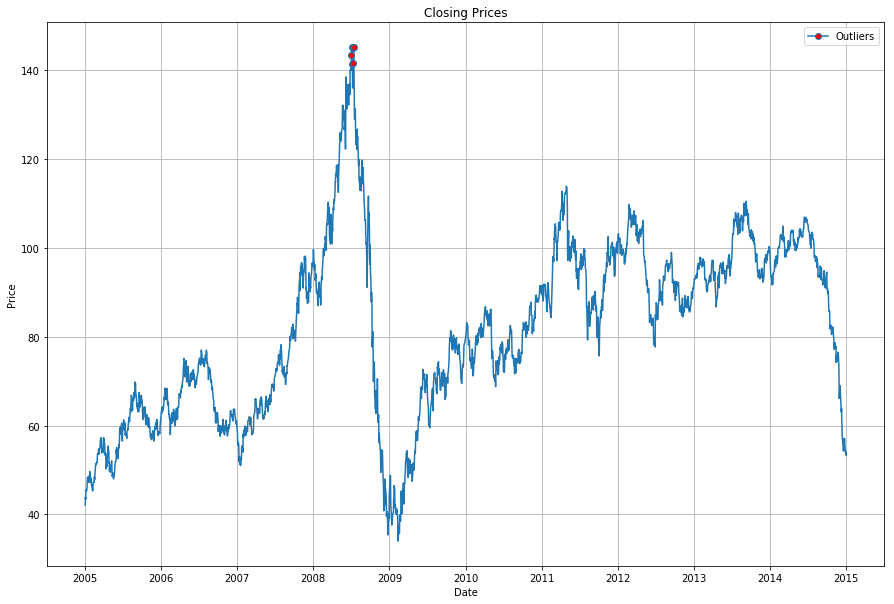

Number of data points: 2517
Number of outliers: 6


In [6]:
cl_df = df_dict['CL']
check_outliers(cl_df)

In [65]:
cl_df['20day_ave_vol'] = cl_df.volume.rolling(window=20, center=False).mean().shift(1)
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0,76.58,53.668,0.78,0,0,0
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,0,74.48,53.668,-0.34,0,0,0
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,0,73.56,52.900,-0.90,0,0,0
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,0,69.54,52.700,1.22,0,0,0
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0,69.32,52.440,0.57,0,0,0


In [13]:
def vol_bo_long(row):
    ''' This is a helper function to determine if a volume breakout long signal has occured.
        
        Args: row - row of a dataframe to use apply function with
        
        Return: 1 if signal occured, 0 if not
    '''
    # Check if today's volume is greater than 200% of 20-day average volume
    if row['volume'] > (2 * row['20day_ave_vol']):
        # Check if close is above prev day close
        if row['close'] > row['high'].shift(1):
            return 1
    else:
        return 0

AttributeError: ("'numpy.float64' object has no attribute 'shift'", 'occurred at index 2011-05-05 00:00:00')

In [20]:
cl_df['close'] - cl_df['high'].shift()

Date
2005-01-03      NaN
2005-01-04    0.810
2005-01-05   -0.740
2005-01-06    1.560
2005-01-07   -0.320
2005-01-10   -0.770
2005-01-11   -1.620
2005-01-12    0.220
2005-01-13    1.440
2005-01-14    0.010
2005-01-18   -0.250
2005-01-19   -1.756
2005-01-20   -1.294
2005-01-21    0.698
2005-01-24   -0.140
2005-01-25    0.400
2005-01-26   -0.970
2005-01-27   -0.900
2005-01-28   -2.470
2005-01-31   -0.650
2005-02-01   -1.130
2005-02-02   -1.550
2005-02-03   -1.100
2005-02-04   -0.250
2005-02-07   -1.970
2005-02-08   -1.070
2005-02-09   -0.240
2005-02-10    0.700
2005-02-11   -0.140
2005-02-14   -0.040
              ...  
2014-11-18   -1.554
2014-11-19   -1.924
2014-11-20    0.384
2014-11-21    0.262
2014-11-24   -2.050
2014-11-25   -2.930
2014-11-26   -2.890
2014-11-28   -8.330
2014-12-01   -4.560
2014-12-02   -2.660
2014-12-03   -1.940
2014-12-04   -1.420
2014-12-05   -2.380
2014-12-08   -3.840
2014-12-09   -1.730
2014-12-10   -3.260
2014-12-11   -3.480
2014-12-12   -3.870
2014-12-15   -3

In [42]:
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol
Date,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,352792.28
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,346788.83
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,331802.13
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,317298.38
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,311659.38


In [43]:
def vol_bo(row):
    if row['volume'] > (2 * row['20day_ave_vol']):
        return 1
    else:
        return 0
    
cl_df['vol_bo'] = cl_df.apply(vol_bo, axis=1)

In [44]:
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo
Date,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,352792.28,0
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,346788.83,0
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,331802.13,0
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,317298.38,0
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,311659.38,0


In [46]:
cl_df['close_gt_prev_h'] = cl_df['close'] - cl_df['high'].shift()

In [52]:
cl_df['close_lt_prev_l'] = cl_df['close'] - cl_df['low'].shift()

In [53]:
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l
Date,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,352792.28,0,-1.72,0,74.48,53.668,0.78
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,346788.83,0,-2.42,0,73.56,53.668,-0.34
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,331802.13,0,-2.98,0,69.54,52.900,-0.90
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,317298.38,0,-1.62,0,69.32,52.700,1.22
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,311659.38,0,-1.05,0,68.23,52.440,0.57


In [48]:
def vol_bo_long(row):
    if (row['vol_bo'] == 1) and (row['close_gt_prev_h'] > 0.0):
        return 1
    else:
        return 0
    
cl_df['vol_bo_long'] = cl_df.apply(vol_bo_long, axis=1)

In [49]:
cl_df.tail(20)

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long
Date,,,,,,,,,,
2014-12-03,67.600,68.230,66.800,67.380,293484.0,0.725233,334275.98,0,-1.940,0
2014-12-04,67.400,68.220,66.090,66.810,237011.0,0.753941,323190.03,0,-1.420,0
2014-12-05,66.800,66.890,65.170,65.840,276529.0,0.802794,321722.03,0,-2.380,0
2014-12-08,65.460,65.550,62.780,63.050,330077.0,0.943311,321983.68,0,-3.840,0
2014-12-09,63.010,64.200,62.250,63.820,322737.0,0.904530,321192.23,0,-1.730,0
2014-12-10,63.330,63.430,60.430,60.940,454025.0,1.049579,327283.68,0,-3.260,0
2014-12-11,61.120,61.680,58.960,59.950,392493.0,1.099440,328021.63,0,-3.480,0
2014-12-12,59.170,59.570,57.340,57.810,414096.0,1.207220,325516.78,0,-3.870,0
2014-12-15,57.070,58.730,55.020,55.910,437833.0,1.302912,328779.73,0,-3.660,0


In [54]:
def vol_bo_short(row):
    if (row['vol_bo'] == 1) and (row['close_lt_prev_l'] < 0.0):
        return 1
    else:
        return 0

In [55]:
cl_df['vol_bo_short'] = cl_df.apply(vol_bo_short, axis=1)

In [68]:
cl_df['20day_high'] = cl_df.high.rolling(window=20, center=False).max().shift(1)
cl_df.tail(100)

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2014-08-11,97.540,98.580,97.370,98.080,265164.0,0.820950,263118.16,0,-0.370,0,103.810,96.550,0.930,0,0,0
2014-08-12,97.840,97.940,96.810,97.370,259142.0,0.785191,263054.51,0,-1.210,0,103.810,96.550,0.000,0,0,0
2014-08-13,97.200,97.780,96.750,97.590,271650.0,0.796272,258766.26,0,-0.350,0,103.810,96.550,0.780,0,0,0
2014-08-14,97.300,97.590,95.260,95.580,362914.0,0.695039,259582.86,0,-2.200,0,103.810,95.260,-1.170,0,0,0
2014-08-15,95.186,97.004,95.038,96.944,268200.6,0.763736,261460.20,0,-0.646,0,103.810,95.038,1.684,0,0,0
2014-08-18,96.316,96.352,94.854,95.346,175458.6,0.683254,265339.36,0,-1.658,0,103.810,94.854,0.308,0,0,0
2014-08-19,94.934,95.442,93.276,93.508,228951.2,0.590685,261231.28,0,-2.844,0,103.810,93.276,-1.346,0,0,0
2014-08-20,93.180,94.158,93.124,93.974,176508.8,0.614154,261873.47,0,-1.468,0,103.340,93.124,0.698,0,0,0
2014-08-21,93.490,94.450,92.500,93.960,236184.0,0.613449,257180.81,0,-0.198,0,103.310,92.500,0.836,0,0,0


In [69]:
cl_df['20day_low'] = cl_df.low.rolling(window=20, center=False).min().shift(1)
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0,76.58,53.668,0.78,0,0,0
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,0,74.48,53.668,-0.34,0,0,0
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,0,73.56,53.668,-0.90,0,0,0
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,0,69.54,52.900,1.22,0,0,0
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0,69.32,52.700,0.57,0,0,0


In [57]:
def range_bo_long(row):
    if row['high'] > row['20day_high']:
        return 1
    else:
        return 0
    
def range_bo_short(row):
    if row['low'] < row['20day_low']:
        return 1
    else:
        return 0

In [56]:
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short
Date,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,352792.28,0,-1.72,0,74.48,53.668,0.78,0
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,346788.83,0,-2.42,0,73.56,53.668,-0.34,0
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,331802.13,0,-2.98,0,69.54,52.900,-0.90,0
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,317298.38,0,-1.62,0,69.32,52.700,1.22,0
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,311659.38,0,-1.05,0,68.23,52.440,0.57,0


In [70]:
cl_df['range_bo_long'] = cl_df.apply(range_bo_long, axis=1)
cl_df['range_bo_short'] = cl_df.apply(range_bo_short, axis=1)

In [71]:
cl_df.tail(100)

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2014-08-11,97.540,98.580,97.370,98.080,265164.0,0.820950,263118.16,0,-0.370,0,103.810,96.550,0.930,0,0,0
2014-08-12,97.840,97.940,96.810,97.370,259142.0,0.785191,263054.51,0,-1.210,0,103.810,96.550,0.000,0,0,0
2014-08-13,97.200,97.780,96.750,97.590,271650.0,0.796272,258766.26,0,-0.350,0,103.810,96.550,0.780,0,0,0
2014-08-14,97.300,97.590,95.260,95.580,362914.0,0.695039,259582.86,0,-2.200,0,103.810,96.550,-1.170,0,0,1
2014-08-15,95.186,97.004,95.038,96.944,268200.6,0.763736,261460.20,0,-0.646,0,103.810,95.260,1.684,0,0,1
2014-08-18,96.316,96.352,94.854,95.346,175458.6,0.683254,265339.36,0,-1.658,0,103.810,95.038,0.308,0,0,1
2014-08-19,94.934,95.442,93.276,93.508,228951.2,0.590685,261231.28,0,-2.844,0,103.810,94.854,-1.346,0,0,1
2014-08-20,93.180,94.158,93.124,93.974,176508.8,0.614154,261873.47,0,-1.468,0,103.340,93.276,0.698,0,0,1
2014-08-21,93.490,94.450,92.500,93.960,236184.0,0.613449,257180.81,0,-0.198,0,103.310,93.124,0.836,0,0,1


In [75]:
longs = cl_df[cl_df['vol_bo_short'] == 1]
longs

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,vol_bo_long,20day_high,20day_low,close_lt_prev_l,vol_bo_short,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2011-05-05,108.78,109.38,98.25,99.8,670082.0,0.907577,308362.35,1,-11.42,0,114.83,105.31,-8.68,1,0,1


In [76]:
cl_df = cl_df[['open', 'high', 'low', 'close', 'volume', 'stds_from_mean', '20day_ave_vol', 'vol_bo', 'close_gt_prev_h', 'close_lt_prev_l', 'vol_bo_long', 'vol_bo_short', '20day_high', '20day_low', 'range_bo_long', 'range_bo_short']]

In [77]:
cl_df.tail()

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,20day_high,20day_low,range_bo_long,range_bo_short
Date,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0.78,0,0,76.58,53.668,0,0
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,-0.34,0,0,74.48,53.668,0,0
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,-0.90,0,0,73.56,53.668,0,1
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,1.22,0,0,69.54,52.900,0,1
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0.57,0,0,69.32,52.700,0,1


In [78]:
cl_df['ma20'] = cl_df['close'].rolling(window=20, center=False).mean()
cl_df['ma50'] = cl_df['close'].rolling(window=50, center=False).mean()
cl_df['ma100'] = cl_df['close'].rolling(window=100, center=False).mean()
cl_df.tail()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,20day_high,20day_low,range_bo_long,range_bo_short,ma20,ma50,ma100
Date,,,,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0.78,0,0,76.58,53.668,0,0,61.4656,71.83068,82.3764
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,-0.34,0,0,74.48,53.668,0,0,60.5176,71.28968,81.9499
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,-0.90,0,0,73.56,53.668,0,1,59.8906,70.71088,81.5168
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,1.22,0,0,69.54,52.900,0,1,59.1466,70.14380,81.0846
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0.57,0,0,69.32,52.700,0,1,58.4661,69.56460,80.6408


In [80]:
def ma_signal(row, ma=20, direction='long'):
    if direction == 'long':
        if row['close'] > row['ma{}'.format(ma)]:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['close'] < row['ma{}'.format(ma)]:
            return 1
        else:
            return 0

In [82]:
cl_df['ma20_long'] = cl_df.apply(lambda row: ma_signal(row), axis=1)
cl_df.tail(44)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,20day_high,20day_low,range_bo_long,range_bo_short,ma20,ma50,ma100,ma20_long
Date,,,,,,,,,,,,,,,,,,,,
2014-10-29,81.550,82.880,81.440,82.200,289766.0,0.021165,344864.78,0,0.540,1.840,0,0,92.960,79.440,0,0,84.3124,89.64452,95.81330,0
2014-10-30,81.930,82.090,80.720,81.120,279510.0,0.033228,339176.63,0,-1.760,-0.320,0,0,91.790,79.440,0,0,83.8179,89.38744,95.58100,0
2014-10-31,81.040,81.270,79.550,80.540,307610.0,0.062440,330674.43,0,-1.550,-0.180,0,0,91.790,79.440,0,0,83.3579,89.11904,95.34240,0
2014-11-03,80.590,80.980,78.080,78.780,398037.0,0.151081,328915.18,0,-2.490,-0.770,0,0,90.740,79.440,0,1,82.7799,88.82164,95.06490,0
2014-11-04,78.220,78.410,75.840,77.190,445741.0,0.231160,334986.33,0,-3.790,-0.890,0,0,90.570,78.080,0,1,82.1969,88.49844,94.76770,0
2014-11-05,77.360,79.350,76.460,78.680,458730.0,0.156117,341045.78,0,0.270,2.840,0,0,88.630,75.840,0,0,81.7654,88.19484,94.48550,0
2014-11-06,78.870,78.980,77.120,77.910,305889.0,0.194898,344200.53,0,-1.440,1.450,0,0,87.950,75.840,0,0,81.3724,87.87544,94.20198,0
2014-11-07,77.860,79.410,77.470,78.650,324844.0,0.157628,341024.53,0,-0.330,1.530,0,0,86.290,75.840,0,0,81.0139,87.55744,93.93030,0
2014-11-10,78.500,79.850,77.130,77.400,338566.0,0.220583,336289.53,0,-2.010,-0.070,0,0,85.870,75.840,0,0,80.5969,87.18624,93.64228,0


In [83]:
cl_df['ma20_short'] = cl_df.apply(lambda row: ma_signal(row, direction='short'), axis=1)
cl_df.tail(44)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,vol_bo_short,20day_high,20day_low,range_bo_long,range_bo_short,ma20,ma50,ma100,ma20_long,ma20_short
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-29,81.550,82.880,81.440,82.200,289766.0,0.021165,344864.78,0,0.540,1.840,...,0,92.960,79.440,0,0,84.3124,89.64452,95.81330,0,1
2014-10-30,81.930,82.090,80.720,81.120,279510.0,0.033228,339176.63,0,-1.760,-0.320,...,0,91.790,79.440,0,0,83.8179,89.38744,95.58100,0,1
2014-10-31,81.040,81.270,79.550,80.540,307610.0,0.062440,330674.43,0,-1.550,-0.180,...,0,91.790,79.440,0,0,83.3579,89.11904,95.34240,0,1
2014-11-03,80.590,80.980,78.080,78.780,398037.0,0.151081,328915.18,0,-2.490,-0.770,...,0,90.740,79.440,0,1,82.7799,88.82164,95.06490,0,1
2014-11-04,78.220,78.410,75.840,77.190,445741.0,0.231160,334986.33,0,-3.790,-0.890,...,0,90.570,78.080,0,1,82.1969,88.49844,94.76770,0,1
2014-11-05,77.360,79.350,76.460,78.680,458730.0,0.156117,341045.78,0,0.270,2.840,...,0,88.630,75.840,0,0,81.7654,88.19484,94.48550,0,1
2014-11-06,78.870,78.980,77.120,77.910,305889.0,0.194898,344200.53,0,-1.440,1.450,...,0,87.950,75.840,0,0,81.3724,87.87544,94.20198,0,1
2014-11-07,77.860,79.410,77.470,78.650,324844.0,0.157628,341024.53,0,-0.330,1.530,...,0,86.290,75.840,0,0,81.0139,87.55744,93.93030,0,1
2014-11-10,78.500,79.850,77.130,77.400,338566.0,0.220583,336289.53,0,-2.010,-0.070,...,0,85.870,75.840,0,0,80.5969,87.18624,93.64228,0,1


In [84]:
cl_df['ma50_long'] = cl_df.apply(lambda row: ma_signal(row, ma=50), axis=1)
cl_df['ma50_short'] = cl_df.apply(lambda row: ma_signal(row, ma=50, direction='short'), axis=1)
cl_df['ma100_long'] = cl_df.apply(lambda row: ma_signal(row, ma=100), axis=1)
cl_df['ma100_short'] = cl_df.apply(lambda row: ma_signal(row, ma=100, direction='short'), axis=1)
cl_df.tail(44)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,range_bo_short,ma20,ma50,ma100,ma20_long,ma20_short,ma50_long,ma50_short,ma100_long,ma100_short
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-29,81.550,82.880,81.440,82.200,289766.0,0.021165,344864.78,0,0.540,1.840,...,0,84.3124,89.64452,95.81330,0,1,0,1,0,1
2014-10-30,81.930,82.090,80.720,81.120,279510.0,0.033228,339176.63,0,-1.760,-0.320,...,0,83.8179,89.38744,95.58100,0,1,0,1,0,1
2014-10-31,81.040,81.270,79.550,80.540,307610.0,0.062440,330674.43,0,-1.550,-0.180,...,0,83.3579,89.11904,95.34240,0,1,0,1,0,1
2014-11-03,80.590,80.980,78.080,78.780,398037.0,0.151081,328915.18,0,-2.490,-0.770,...,1,82.7799,88.82164,95.06490,0,1,0,1,0,1
2014-11-04,78.220,78.410,75.840,77.190,445741.0,0.231160,334986.33,0,-3.790,-0.890,...,1,82.1969,88.49844,94.76770,0,1,0,1,0,1
2014-11-05,77.360,79.350,76.460,78.680,458730.0,0.156117,341045.78,0,0.270,2.840,...,0,81.7654,88.19484,94.48550,0,1,0,1,0,1
2014-11-06,78.870,78.980,77.120,77.910,305889.0,0.194898,344200.53,0,-1.440,1.450,...,0,81.3724,87.87544,94.20198,0,1,0,1,0,1
2014-11-07,77.860,79.410,77.470,78.650,324844.0,0.157628,341024.53,0,-0.330,1.530,...,0,81.0139,87.55744,93.93030,0,1,0,1,0,1
2014-11-10,78.500,79.850,77.130,77.400,338566.0,0.220583,336289.53,0,-2.010,-0.070,...,0,80.5969,87.18624,93.64228,0,1,0,1,0,1


In [85]:
cl_df['bb_high'] = cl_df['ma20'] + (2 * cl_df['close'].rolling(window=20, center=False).std())
cl_df['bb_low'] = cl_df['ma20'] - (2 * cl_df['close'].rolling(window=20, center=False).std())
cl_df.tail()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,ma50,ma100,ma20_long,ma20_short,ma50_long,ma50_short,ma100_long,ma100_short,bb_high,bb_low
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0.78,...,71.83068,82.3764,0,1,0,1,0,1,72.792675,50.138525
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,-0.34,...,71.28968,81.9499,0,1,0,1,0,1,70.647242,50.387958
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,-0.90,...,70.71088,81.5168,0,1,0,1,0,1,70.104360,49.676840
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,1.22,...,70.14380,81.0846,0,1,0,1,0,1,68.713782,49.579418
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0.57,...,69.56460,80.6408,0,1,0,1,0,1,67.645476,49.286724


In [87]:
def bb_trade(row, direction='long'):
    if direction == 'long':
        if row['low'] < row['bb_low']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['high'] > row['bb_high']:
            return 1
        else:
            return 0
        
cl_df['bb_long'] = cl_df.apply(lambda row: bb_trade(row), axis=1)
cl_df['bb_short'] = cl_df.apply(lambda row: bb_trade(row, direction='short'), axis=1)
cl_df.tail(34)

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,ma20_long,ma20_short,ma50_long,ma50_short,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-12,77.500,78.080,76.630,77.180,377734.0,0.231663,329788.73,0,-0.860,0.760,...,0,1,0,1,0,1,84.141853,76.201947,0,0
2014-11-13,76.950,77.160,74.070,74.210,464193.0,0.381245,323677.58,0,-3.870,-2.420,...,0,1,0,1,0,1,84.372341,75.137459,1,0
2014-11-14,74.360,76.300,73.250,75.820,372574.0,0.300159,326742.80,0,-1.340,1.750,...,0,1,0,1,0,1,84.171710,74.672690,1,0
2014-11-17,75.924,76.176,74.718,75.644,264932.8,0.309023,335463.87,0,-0.656,2.394,...,0,1,0,1,0,1,83.935084,74.250716,0,0
2014-11-18,75.510,76.456,74.140,74.622,193749.0,0.360495,337234.41,0,-1.554,-0.096,...,0,1,0,1,0,1,83.643089,73.749511,0,0
2014-11-19,74.248,75.412,73.904,74.532,289259.0,0.365028,334588.84,0,-1.924,0.392,...,0,1,0,1,0,1,83.597278,73.196522,0,0
2014-11-20,74.322,76.248,74.194,75.796,201968.8,0.301368,330818.04,0,0.384,1.892,...,0,1,0,1,0,1,83.100139,73.064261,0,0
2014-11-21,76.290,77.830,75.620,76.510,286451.0,0.265408,322751.83,0,0.262,2.316,...,0,1,0,1,0,1,82.723646,72.990754,0,0
2014-11-24,76.620,77.020,75.450,75.780,194737.0,0.302173,322864.38,0,-2.050,0.160,...,0,1,0,1,0,1,82.310480,72.881920,0,0


In [88]:
cl_df['pct_change_1day'] = cl_df['close'].pct_change()
cl_df.head()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,ma20_short,ma50_long,ma50_short,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,43.10,43.10,41.25,42.12,69484.0,1.997435,NaN,0,NaN,NaN,...,0,0,0,0,0,NaN,NaN,0,0,NaN
2005-01-04,42.18,44.13,41.85,43.91,100665.0,1.907283,NaN,0,0.81,2.66,...,0,0,0,0,0,NaN,NaN,0,0,0.042498
2005-01-05,43.90,44.00,42.60,43.39,91011.0,1.933473,NaN,0,-0.74,1.54,...,0,0,0,0,0,NaN,NaN,0,0,-0.011842
2005-01-06,43.39,45.75,42.80,45.56,122411.0,1.824182,NaN,0,1.56,2.96,...,0,0,0,0,0,NaN,NaN,0,0,0.050012
2005-01-07,45.50,46.10,44.75,45.43,99725.0,1.830730,NaN,0,-0.32,2.63,...,0,0,0,0,0,NaN,NaN,0,0,-0.002853


In [89]:
cl_df['pct_change_5day'] = cl_df['close'].pct_change(periods=5)
cl_df['pct_change_10day'] = cl_df['close'].pct_change(periods=10)
cl_df['pct_change_20day'] = cl_df['close'].pct_change(periods=20)
cl_df.tail()

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,open,high,low,close,volume,stds_from_mean,20day_ave_vol,vol_bo,close_gt_prev_h,close_lt_prev_l,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,1.306437,358766.18,0,-1.72,0.78,...,0,1,72.792675,50.138525,0,0,-0.022409,-0.013393,-0.083689,-0.246322
2014-12-26,55.86,56.59,54.51,54.73,138280.0,1.362342,352792.28,0,-2.42,-0.34,...,0,1,70.647242,50.387958,0,0,-0.019878,0.008662,-0.087073,-0.257294
2014-12-29,55.05,55.74,52.90,53.61,253089.0,1.418750,346788.83,0,-2.98,-0.90,...,0,1,70.104360,49.676840,0,0,-0.020464,-0.059606,-0.072652,-0.189569
2014-12-30,53.72,54.32,52.70,54.12,230228.0,1.393064,331802.13,0,-1.62,1.22,...,0,1,68.713782,49.579418,0,0,0.009513,-0.020630,-0.032016,-0.215652
2014-12-31,53.87,54.02,52.44,53.27,247510.0,1.435874,317298.38,0,-1.05,0.57,...,0,1,67.645476,49.286724,0,0,-0.015706,-0.067402,-0.048682,-0.203499


In [90]:
ave_bb_long_5day_return = cl_df[cl_df['bb_long'] == 1]['pct_change_5day'].mean()
ave_bb_long_5day_return

-0.05442060595641749

In [91]:
ave_bb_short_5day_return = cl_df[cl_df['bb_short'] == 1]['pct_change_5day'].mean()
ave_bb_short_5day_return

0.052146529537547656